In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/openaimer/sample_submission.csv
/kaggle/input/openaimer/OpenAImer2025_Image_Classification/OpenAImer/test/YehKarkeDikhaao63392.jpg
/kaggle/input/openaimer/OpenAImer2025_Image_Classification/OpenAImer/test/YehKarkeDikhaao60822.jpg
/kaggle/input/openaimer/OpenAImer2025_Image_Classification/OpenAImer/test/YehKarkeDikhaao287801.jpg
/kaggle/input/openaimer/OpenAImer2025_Image_Classification/OpenAImer/test/YehKarkeDikhaao385827.jpg
/kaggle/input/openaimer/OpenAImer2025_Image_Classification/OpenAImer/test/YehKarkeDikhaao175511.jpg
/kaggle/input/openaimer/OpenAImer2025_Image_Classification/OpenAImer/test/YehKarkeDikhaao249279.jpg
/kaggle/input/openaimer/OpenAImer2025_Image_Classification/OpenAImer/test/YehKarkeDikhaao225936.jpg
/kaggle/input/openaimer/OpenAImer2025_Image_Classification/OpenAImer/test/YehKarkeDikhaao450136.jpg
/kaggle/input/openaimer/OpenAImer2025_Image_Classification/OpenAImer/test/YehKarkeDikhaao410832.jpg
/kaggle/input/openaimer/OpenAImer2025_Image_Classificati

Using device: cuda
Training dataset size: 3043
Classes: ['bus', 'car', 'cat', 'cricket', 'dog', 'football', 'product']
Starting Supervised Contrastive Pretraining...


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:05<00:00, 17.4MB/s]


ResNet50WithContrastiveHead(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

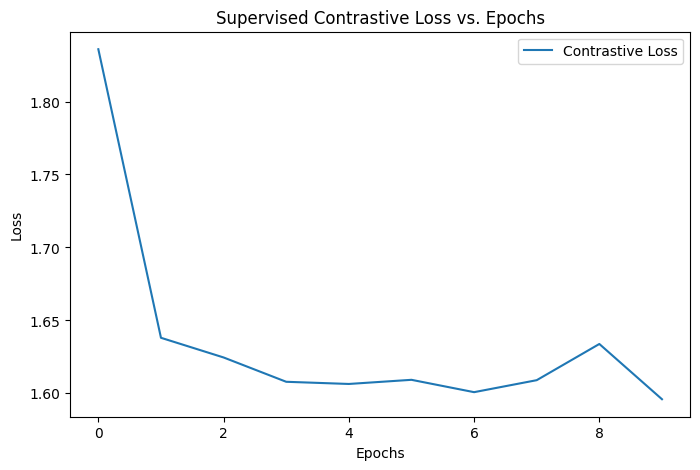

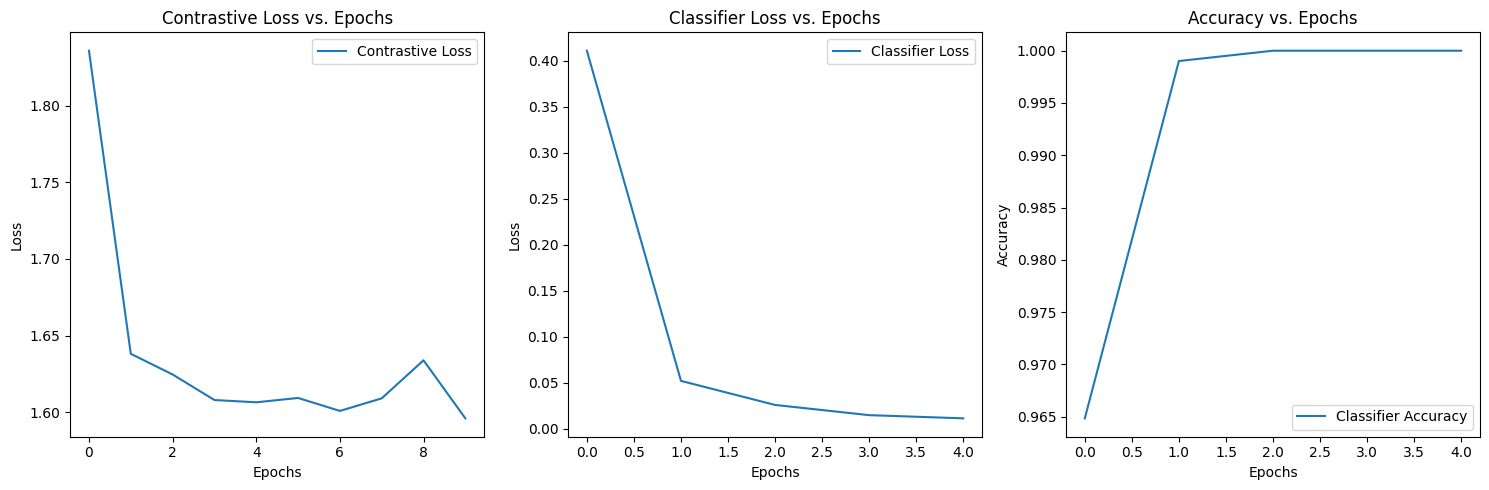

In [3]:
import os
import re
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from PIL import Image
import pandas as pd
from collections import defaultdict


random_seed = 42
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = True


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


class EnhancedImageFolder(ImageFolder):
    def __getitem__(self, index):
        img, label = super().__getitem__(index)
        return img, label, index


def create_data_loaders(dataset, batch_size=32):
    
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    return loader

class SpatialAttention(nn.Module):
    def __init__(self, in_channels):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.conv2 = nn.Conv2d(in_channels // 8, in_channels, kernel_size=1)
        
    def forward(self, x):
        
        avg_pool = F.avg_pool2d(x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
        avg_pool = self.conv1(avg_pool)
        avg_pool = F.relu(avg_pool)
        avg_pool = self.conv2(avg_pool)
        
       
        attention_weights = torch.sigmoid(avg_pool)
        
        
        return x * attention_weights


class ResNet50WithContrastiveHead(nn.Module):
    def __init__(self, feature_dim=128, num_classes=None):
        super(ResNet50WithContrastiveHead, self).__init__()
       
        resnet = models.resnet50(weights='IMAGENET1K_V2')
        
        
        self.features = nn.Sequential(*list(resnet.children())[:-2])
        
        
        for param in self.features.parameters():
            param.requires_grad = True
        
        
        self.attention = SpatialAttention(2048)  
        
        
        self.gap = nn.AdaptiveAvgPool2d(1)
        
        
        self.projection = nn.Sequential(
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Linear(2048, feature_dim)
        )
        
        
        self.classifier = None
        if num_classes is not None:
            self.classifier = nn.Linear(2048, num_classes)
    
    def forward_features(self, x):
        
        features = self.features(x)
        
        
        attended_features = self.attention(features)
        
        
        pooled = self.gap(attended_features).view(x.size(0), -1)
        
        return pooled
    
    def forward(self, x):
        features = self.forward_features(x)
        
        
        projection = F.normalize(self.projection(features), p=2, dim=1)
        
        
        if self.classifier is not None:
            class_output = self.classifier(features)
            return projection, class_output
        
        return projection
    
    def add_classifier(self, num_classes):
        self.classifier = nn.Linear(2048, num_classes)
        return self


class SupConLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
    
    def forward(self, features, labels):
        """
        features: normalized embeddings [batch_size, feature_dim]
        labels: ground truth labels [batch_size]
        """
        device = features.device
        batch_size = features.shape[0]
        labels = labels.contiguous().view(-1, 1)
        
        
        mask = torch.eq(labels, labels.T).float().to(device)
        
        
        identity_mask = torch.eye(batch_size, dtype=torch.bool, device=device)
        mask = mask.masked_fill(identity_mask, 0)
        
        
        similarity_matrix = torch.matmul(features, features.T) / self.temperature
        
        
        logits_max, _ = torch.max(similarity_matrix, dim=1, keepdim=True)
        similarity_matrix_exp = torch.exp(similarity_matrix - logits_max.detach())
        
        
        denominators = torch.sum(
            similarity_matrix_exp * (~identity_mask).float(), 
            dim=1, 
            keepdim=True
        )
        
        
        log_probs = torch.log(similarity_matrix_exp / (denominators + 1e-8) + 1e-8)
        
        
        pos_mask = mask.bool()
        
        
        loss = torch.tensor(0.0, device=device, requires_grad=True)
        
        
        for i in range(batch_size):
            if torch.sum(pos_mask[i]) > 0:
                
                pos_pair_losses = log_probs[i][pos_mask[i]]
                
                anchor_loss = -torch.sum(pos_pair_losses) / torch.sum(pos_mask[i])
                loss = loss + anchor_loss
        
        
        return loss / batch_size


class SupConLossAlt(nn.Module):
    def __init__(self, temperature=0.07):
        super(SupConLossAlt, self).__init__()
        self.temperature = temperature
        
    def forward(self, features, labels):
        
        batch_size = features.shape[0]
        labels = labels.contiguous().view(-1, 1)
        
        
        mask = torch.eq(labels, labels.T).float()
        
        
        mask = mask - torch.eye(batch_size, device=features.device)
        mask = mask.clamp(min=0)
        
        
        anchor_dot_contrast = torch.div(
            torch.matmul(features, features.T),
            self.temperature
        )
        
        
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()
        
        
        exp_logits = torch.exp(logits)
        
        
        logits_mask = torch.ones_like(mask) - torch.eye(batch_size, device=features.device)
        
        
        exp_logits_sum = torch.sum(exp_logits * logits_mask, dim=1, keepdim=True)
        log_prob = logits - torch.log(exp_logits_sum + 1e-8)
        
        
        mask_sum = torch.sum(mask, dim=1)
        mask_sum = torch.clamp(mask_sum, min=1.0)
        
        loss = torch.sum(-(mask * log_prob) / mask_sum.view(-1, 1)) / batch_size
        
        return loss


def train_contrastive(model, train_loader, criterion, optimizer, num_epochs=10):
    """
    Train the model using supervised contrastive loss
    """
    model.to(device)
    
    train_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, labels, _ in train_loader:
            if len(inputs) <= 1:  
                continue
                
            inputs, labels = inputs.to(device), labels.to(device)
            
            
            optimizer.zero_grad()
            
           
            embeddings = model(inputs)
            
          
            loss = criterion(embeddings, labels)
            
           
            loss.backward()
            optimizer.step()
            
         
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Contrastive Loss: {epoch_loss:.4f}")
    

    torch.save(model.state_dict(), 'contrastive_pretrained_model.pth')
    return model, train_losses

def train_classifier(model, train_loader, criterion, optimizer, num_epochs=10):
    
    model.to(device)
    
    train_losses = []
    train_accs = []
    
    for epoch in range(num_epochs):
   
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels, _ in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
       
            _, class_outputs = model(inputs)
            loss = criterion(class_outputs, labels)
            
  
            loss.backward()
            optimizer.step()
            
          
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(class_outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Classifier Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")
    
  
    torch.save(model.state_dict(), 'final_supcon_resnet50_model.pth')
    return model, train_losses, train_accs


def plot_training_results(contrastive_losses, classifier_losses=None, classifier_accs=None):
    
    if classifier_losses is None:
       
        plt.figure(figsize=(8, 5))
        plt.plot(contrastive_losses, label='Contrastive Loss')
        plt.title('Supervised Contrastive Loss vs. Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig('contrastive_training_results.png')
    else:
      
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.plot(contrastive_losses, label='Contrastive Loss')
        plt.title('Contrastive Loss vs. Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 3, 2)
        plt.plot(classifier_losses, label='Classifier Loss')
        plt.title('Classifier Loss vs. Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 3, 3)
        plt.plot(classifier_accs, label='Classifier Accuracy')
        plt.title('Accuracy vs. Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.tight_layout()
        plt.savefig('full_training_results.png')


def extract_id_from_filename(filename):
    match = re.search(r'YehKarkeDikhaao(\d+)\.jpe?g', filename, re.IGNORECASE)
    if match:
        return int(match.group(1))
    else:
        return None


def generate_predictions_csv(model, test_dir, class_names, output_csv='predictions.csv'):
    
    model.eval()
    model.to(device)
    

    image_files = [f for f in os.listdir(test_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    

    results = []
   
    for img_file in image_files:
      
        img_id = extract_id_from_filename(img_file)
        if img_id is None:
            print(f"Warning: Could not extract ID from {img_file}, skipping...")
            continue
            
     
        img_path = os.path.join(test_dir, img_file)
        image = Image.open(img_path).convert('RGB')
        image_tensor = data_transforms(image).unsqueeze(0).to(device)  # Add batch dimension
        
   
        with torch.no_grad():
            _, outputs = model(image_tensor)  # Get classifier outputs
            _, pred = torch.max(outputs, 1)
            class_idx = pred.item()  # Convert to Python int
            class_name = class_names[class_idx]
        
     
        results.append({
            'id': img_id,
            'label': class_name
        })
    
    df = pd.DataFrame(results)
    df = df.sort_values('id')
    

    print("Preview of generated DataFrame:")
    print(df.head())
    
    df.to_csv(output_csv, index=False)
    print(f"Saved predictions to {output_csv}")
    
    return df
   
def main():
   
    batch_size = 32
    contrastive_epochs = 10
    classifier_epochs = 5
    contrastive_lr = 0.0001
    classifier_lr = 0.001
    feature_dim = 128
    temperature = 0.07
    
    train_dir = "/kaggle/input/openaimer/OpenAImer2025_Image_Classification/OpenAImer/train"  # Train directory
    test_dir = "/kaggle/input/openaimer/OpenAImer2025_Image_Classification/OpenAImer/test"    # Test directory
 
    full_dataset = EnhancedImageFolder(root=train_dir, transform=data_transforms)
    class_names = full_dataset.classes
    num_classes = len(class_names)
    print(f"Training dataset size: {len(full_dataset)}")
    print(f"Classes: {class_names}")
    
 
    train_loader = create_data_loaders(full_dataset, batch_size)
    
    print("Starting Supervised Contrastive Pretraining...")
    
    model = ResNet50WithContrastiveHead(feature_dim=feature_dim)
    
    for name, param in model.named_parameters():
        param.requires_grad = True
        
    print(model)
    
    contrastive_criterion = SupConLossAlt(temperature=temperature)
    
    contrastive_optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=contrastive_lr)
    
    model, contrastive_losses = train_contrastive(
        model, train_loader, contrastive_criterion, contrastive_optimizer, contrastive_epochs
    )
    
    plot_training_results(contrastive_losses)
    
    print("Adding classifier head and fine-tuning...")
    
    model.add_classifier(num_classes)
    
    for param in model.features.parameters():
        param.requires_grad = False
    for param in model.attention.parameters():
        param.requires_grad = False
    for param in model.projection.parameters():
        param.requires_grad = False
    
    for param in model.classifier.parameters():
        param.requires_grad = True
    
    classifier_criterion = nn.CrossEntropyLoss()
    classifier_optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=classifier_lr)
    
    model, classifier_losses, classifier_accs = train_classifier(
        model, train_loader, classifier_criterion, classifier_optimizer, classifier_epochs
    )
    
    plot_training_results(contrastive_losses, classifier_losses, classifier_accs)
    
    generate_predictions_csv(model, test_dir, class_names, 'predictions_supcon.csv')
    
    print(f"Training complete.")
    print(f"Contrastive model saved as 'contrastive_pretrained_model.pth'")
    print(f"Final model saved as 'final_supcon_resnet50_model.pth'")
    print(f"Predictions saved to 'predictions_supcon.csv'")
    print(f"Training visualizations saved to 'contrastive_training_results.png' and 'full_training_results.png'")

if __name__ == "__main__":
    main()